In [ ]:
pip install pandas scikit-learn numpy matplotlib seaborn Flask


In [ ]:
pip install tensorflow

In [ ]:
import math
import pandas as pd
import numpy as np
import csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Concatenate
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

We use this dataSet https://corgis-edu.github.io/corgis/csv/music/. For our prediction code



In [ ]:
# Read and process the file
def ReadFile(filename="music.csv"):
    with open(filename, newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        mentions = dict()

        for line in reader:
            user = line[6]  # Assuming 'artist.name' is the user identifier
            product = line[23]  # Assuming 'song.id' is the product identifier
            user_terms_index = 24  # Column index for 'artist.terms'

            try:
                rate = float(line[0])  # 'artist.familiarity' as rating
                user_terms = line[user_terms_index]
            except ValueError:
                continue  # Skip lines with non-numeric values

            if user not in mentions:
                mentions[user] = {"ratings": dict(), "terms": user_terms}
            mentions[user]["ratings"][product] = rate

    return mentions


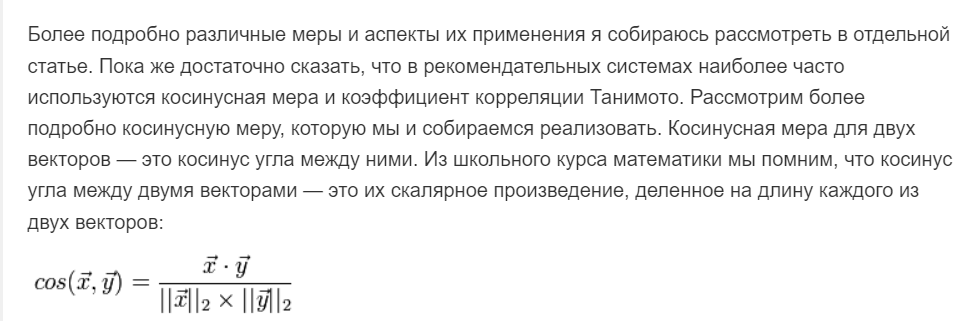

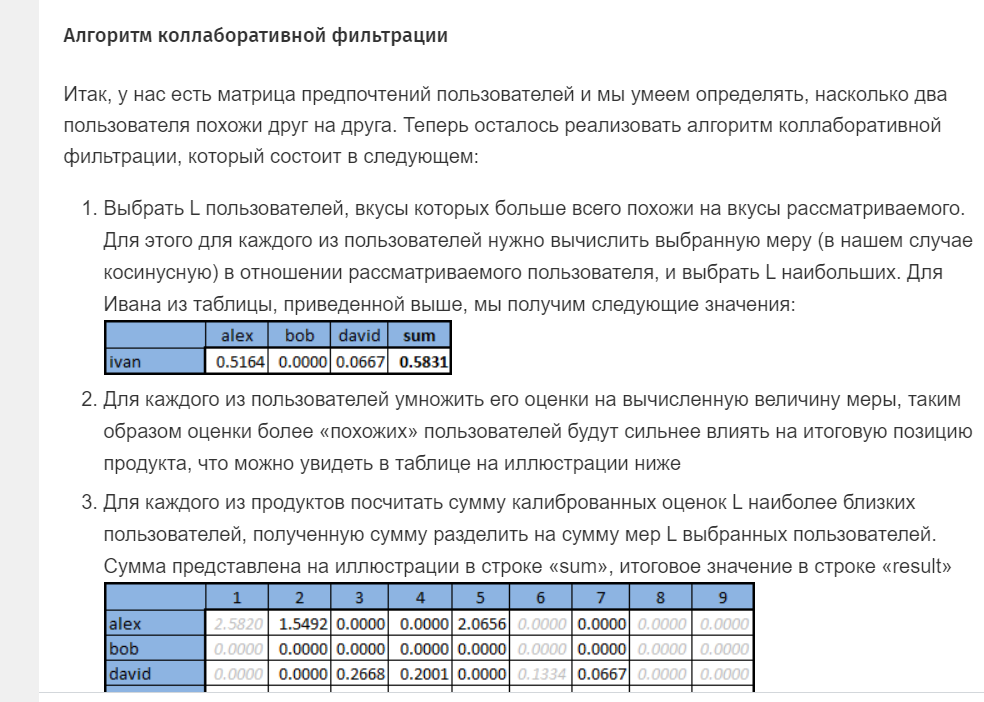

In [ ]:
def dotProduct(vecA, vecB):
    # Identify common keys (products) in both vectors
    common_keys = set(vecA["ratings"]).intersection(vecB["ratings"])

    # Sum the product of ratings for common products
    return sum(vecA["ratings"][key] * vecB["ratings"][key] for key in common_keys)

In [ ]:
# Modify distCosine function
def distCosine(vecA, vecB):
    dotProdA = dotProduct(vecA, vecA)
    dotProdB = dotProduct(vecB, vecB)

    if dotProdA == 0.0 or dotProdB == 0.0:
        return 0.0

    return dotProduct(vecA, vecB) / (math.sqrt(dotProdA) * math.sqrt(dotProdB))

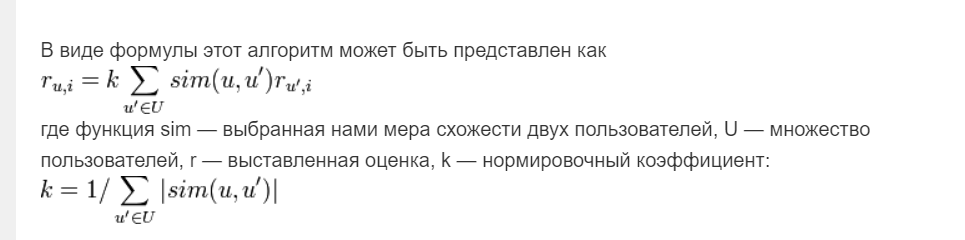

In [ ]:
# Recommendation generation
def makeRecommendation(userID, userRates, nBestUsers, nBestProducts):
    if userID not in userRates:
        print(f"User '{userID}' not found in the dataset.")
        return []

    matches = [(u, distCosine(userRates[userID], userRates[u])) for u in userRates if u != userID]
    bestMatches = sorted(matches, key=lambda x: (x[1], x[0]), reverse=True)[:nBestUsers]

    if not bestMatches:
        print(f"No meaningful matches found for user '{userID}'.")
        return []

    print(f"Most correlated with '{userID}' users:")
    for line in bestMatches:
        print(f"  UserID: {line[0]:6}  Coeff: {line[1]:6.4f}")

    sim = dict()
    sim_all = sum([x[1] for x in bestMatches])

    for relatedUser in bestMatches:
        for product in userRates[relatedUser[0]]:
            if product not in userRates[userID]:
                if product not in sim:
                    sim[product] = 0.0
                sim[product] += userRates[relatedUser[0]][product] * relatedUser[1]

    for product in sim:
        sim[product] /= sim_all

    bestProducts = sorted(sim.items(), key=lambda x: (x[1], x[0]), reverse=True)[:nBestProducts]
    return bestProducts


In [ ]:
# Load the artist data and user ratings
artists_data = pd.read_csv('/content/music.csv')

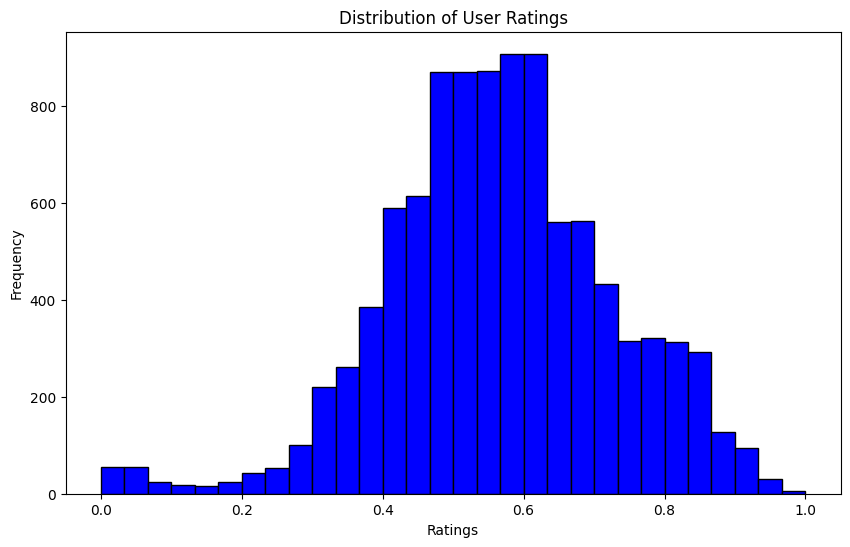

In [ ]:
userRates = ReadFile()
all_ratings = []
for user in userRates:
    all_ratings.extend(userRates[user]["ratings"].values())
plt.figure(figsize=(10, 6))
plt.hist(all_ratings, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()




In [ ]:
terms_frequency = {}
for user in userRates:
    term = userRates[user]["terms"]
    if term in terms_frequency:
        terms_frequency[term] += 1
    else:
        terms_frequency[term] = 1

# Sorting terms for better visualization
sorted_terms = sorted(terms_frequency.items(), key=lambda x: x[1], reverse=True)

# Unpacking for plotting
terms, frequencies = zip(*sorted_terms)

From data set artist.terms = genre. 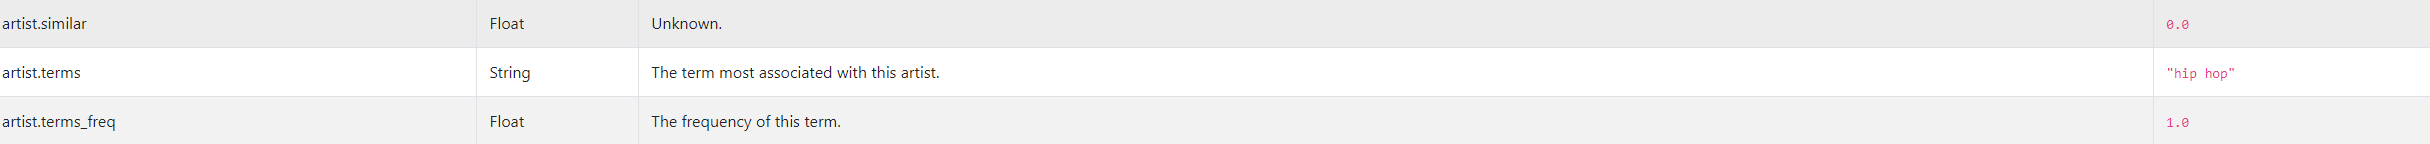

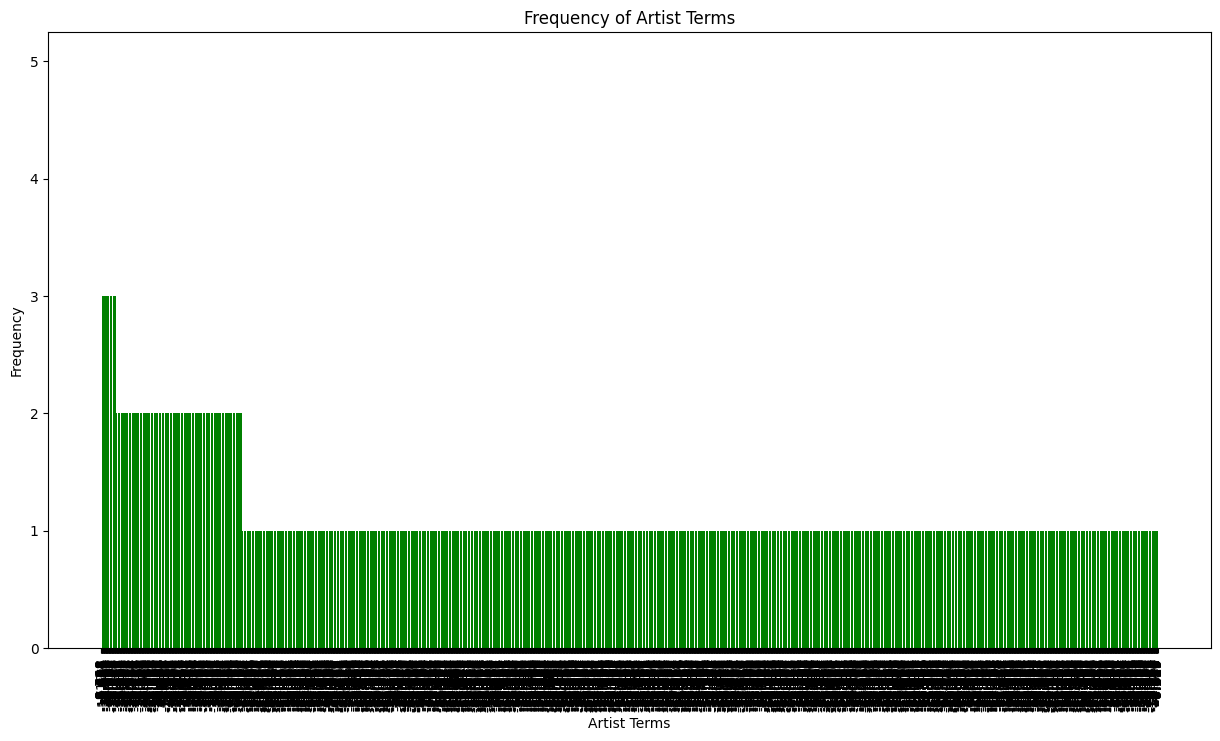

In [ ]:
# Plotting the frequency of artist terms
plt.figure(figsize=(15, 8))
plt.bar(terms, frequencies, color='green')
plt.title('Frequency of Artist Terms')
plt.xlabel('Artist Terms')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate labels for better readability
plt.show()
# Convert userRates dictionary to numpy array
num_users = len(userRates)
num_products = max(len(userRates[user]["ratings"]) for user in userRates)

In [ ]:
# Prepare data for neural network
X_train = np.zeros((num_users, num_products))
y_train = np.zeros((num_users, num_products))
user_terms_train = []

In [ ]:
# Extract user terms for one-hot encoding
for user in userRates:
    user_terms_train.append(userRates[user]["terms"])

# One-hot encode user terms
encoder = OneHotEncoder()
user_terms_encoded = encoder.fit_transform(np.array(user_terms_train).reshape(-1, 1)).toarray()
num_user_terms = user_terms_encoded.shape[1]

# Prepare the training data
for i, user in enumerate(userRates):
    for j, product in enumerate(userRates[user]["ratings"]):
        X_train[i, j] = userRates[user]["ratings"][product]
        y_train[i, j] = userRates[user]["ratings"][product]


In [ ]:
# Concatenate user ratings and user terms
X_train = np.concatenate((X_train, user_terms_encoded), axis=1)

# Neural Network Architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=num_products + num_user_terms))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_products, activation='linear'))  # Output layer

In [ ]:
# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10)


Epoch 1/10
138/138 [==============================] - 2s 5ms/step - loss: 0.0223
Epoch 2/10
138/138 [==============================] - 1s 5ms/step - loss: 0.0040
Epoch 3/10
138/138 [==============================] - 1s 7ms/step - loss: 0.0021
Epoch 4/10
138/138 [==============================] - 1s 5ms/step - loss: 0.0013
Epoch 5/10
138/138 [==============================] - 1s 6ms/step - loss: 8.9222e-04
Epoch 6/10
138/138 [==============================] - 1s 6ms/step - loss: 6.2241e-04
Epoch 7/10
138/138 [==============================] - 1s 7ms/step - loss: 4.7758e-04
Epoch 8/10
138/138 [==============================] - 1s 6ms/step - loss: 3.8398e-04
Epoch 9/10
138/138 [==============================] - 1s 6ms/step - loss: 3.0663e-04
Epoch 10/10
138/138 [==============================] - 1s 6ms/step - loss: 2.5082e-04


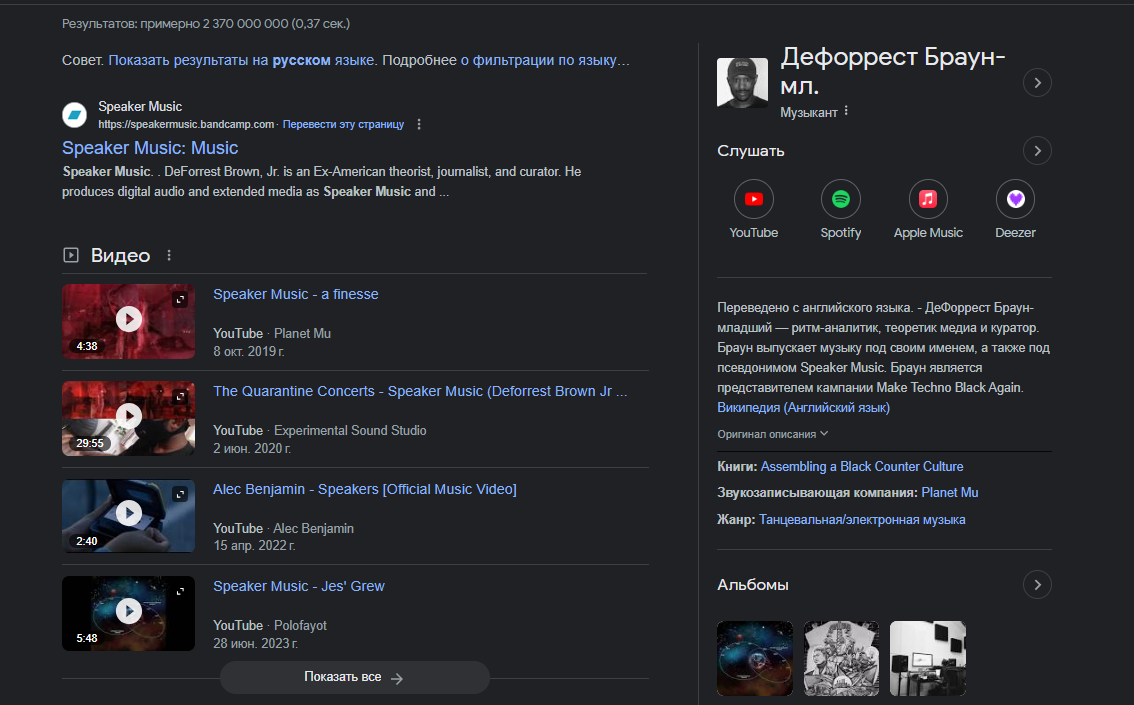

In [ ]:
# Make recommendations using the trained model
rec = makeRecommendation('Speaker', userRates, 15, 15)


Most correlated with 'Speaker' users:
  UserID: Sigmatropic  Coeff: 1.0000
  UserID: Al Toomer  Coeff: 1.0000
  UserID: A Challenge Of Honour  Coeff: 1.0000
  UserID: SA(c)amus Egan  Coeff: 0.7071
  UserID: Kristine W.  Coeff: 0.5774
  UserID: Mavado  Coeff: 0.5774
  UserID: Charlotte Gainsbourg  Coeff: 0.5774
  UserID: BA(c)nabar  Coeff: 0.5774
  UserID: Flamin' Groovies  Coeff: 0.5000
  UserID: Brian Dullaghan  Coeff: 0.5000
  UserID: George Nooks  Coeff: 0.4472
  UserID: George Jones  Coeff: 0.4472
  UserID: Curtis Mayfield  Coeff: 0.4472
  UserID: Jay PA(c)rez  Coeff: 0.3780
  UserID: Bad Religion  Coeff: 0.3780


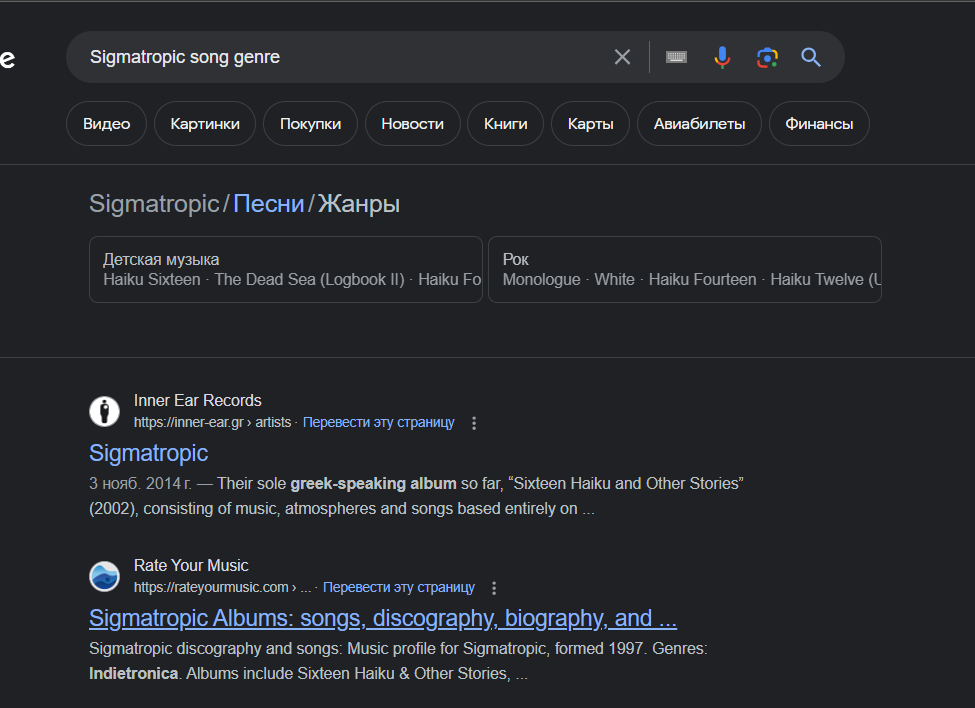

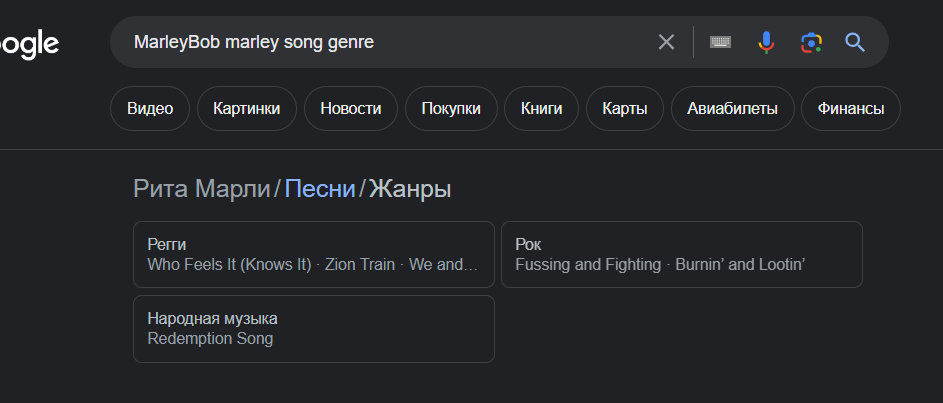

In [ ]:
# Make recommendations using the trained model
rec = makeRecommendation('Bob Marley', userRates, 15, 15)


Most correlated with 'Bob Marley' users:
  UserID: Dilated Peoples Featuring Black Thought  Coeff: 0.5007
  UserID: T-la Rock  Coeff: 0.4998
  UserID: The Advantage  Coeff: 0.4998
  UserID: Ms. Dynamite / Kymani Marley  Coeff: 0.4998
  UserID: Janet Paschal/Charlotte Ritchie/David Phelps  Coeff: 0.4998
  UserID: Liquid Spill  Coeff: 0.4998
  UserID: Eyes Cream  Coeff: 0.4998
  UserID: London Theatre Orchestra  Coeff: 0.3540
  UserID: Raphael  Coeff: 0.3540
  UserID: Embrace the End  Coeff: 0.3540
  UserID: Soul Embraced  Coeff: 0.3534
  UserID: Colin James  Coeff: 0.3534
  UserID: UKW     Coeff: 0.2891
  UserID: Iggy Pop  Coeff: 0.2891
  UserID: Kristine W.  Coeff: 0.2891


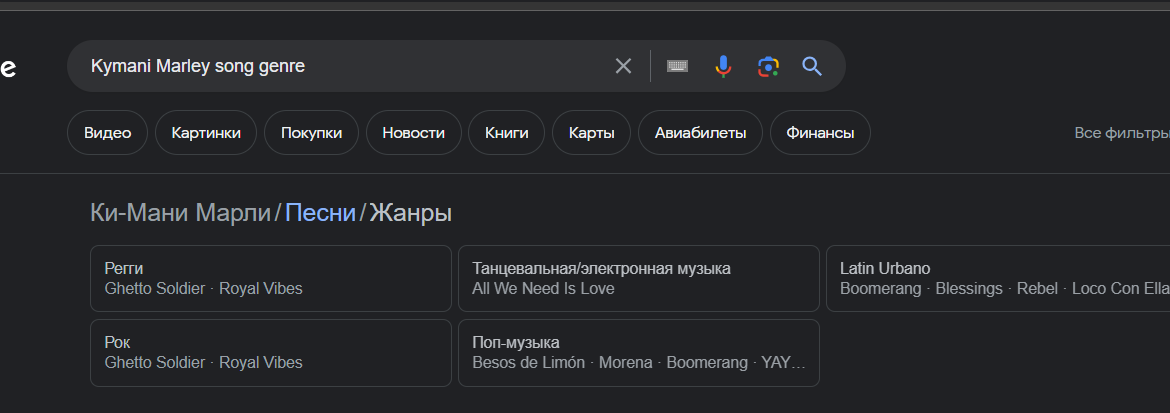

You can see that our model can select the one that is most similar in genre as well as popularity to the one we are looking for.

In [ ]:
!pip install joblib


In [ ]:
import joblib

# Save your Keras model
model.save('music_recommendation_model.h5')

# Assuming 'userRates' is your data dictionary
joblib.dump(userRates, 'userRates.pkl')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['userRates.pkl']

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved Keras model
model = load_model('/content/music_recommendation_model.h5')

# Load the user rates data
userRates = joblib.load('/content/userRates.pkl')


In [ ]:
!pip install flask-ngrok


We work in Jupyter. But this information we give for you. Cuz we use localhost for our telegram bot


This part just for us, checking our bot


In [ ]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
import numpy as np
from flask import Flask, request, jsonify

app = Flask(__name__)
model = load_model('my_model.h5')
@app.route('/recommend', methods=['POST'])
def recommend():
    try:
        data = request.json
        artist_name = data['artist_name']
        logging.info(f"Received artist name: {artist_name}")

        recommendations = makeRecommendation(artist_name, userRates, 15, 15)
        logging.info(f"Recommendations: {recommendations}")

        if not recommendations:
            return jsonify({'results': 'No recommendations found.'})
        else:
            formatted_recommendations = format_recommendations(recommendations)
            return jsonify({'results': formatted_recommendations})
    except Exception as e:
        logging.exception("An error occurred during recommendation generation")
        return jsonify({'error': str(e)})
if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
